In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from time import sleep

cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
cmap_light = ListedColormap(["#FFBBBB", "#BBFFBB", "#BBBBFF"])

%matplotlib inline

In [0]:
def linear(H):
    return H


def ReLU(H):  # Rectified Linear Unit
    return H*(H > 0)


def sigmoid(H):
    return 1/(1 + np.exp(-H))


def softmax(H):
    eH = np.exp(H)
    return eH/eH.sum(axis=1, keepdims=True)


def cross_entropy(Y, P_hat):
    # return -(1/len(Y)) * np.sum(Y*np.log(P_hat) + (1-Y)*np.log(1-P_hat))
    # return -np.sum(Y*np.log(P_hat))
    return -(1/len(Y)) * np.sum(Y*np.log(P_hat))


def OLS(Y, Y_hat):
    return (1/(2*len(Y))) * np.sum((Y - Y_hat)**2)


def one_hot_encode(y):
    N = len(y)
    k = len(set(y))
    Y = np.zeros((N, k))

    for i in range(N):
        Y[i, y[i]] = 1

    return Y


def derivative(Z, a):
    if a == linear:
        return 1

    elif a == sigmoid:
        return Z*(1-Z)

    elif a == np.tanh:
        return 1 - Z*Z

    elif a == ReLU:
        return (Z > 0).astype(int)
    else:
        ValueError("Unknown Activation")

In [0]:
class ANN():
    def __init__(self, architecture, activations=None, mode=0):
        self.mode = mode
        self.architecture = architecture
        self.activations = activations
        self.L = len(architecture) + 1

    def fit(self, X, y, eta=1e-3, epochs=1e3, show_curve=False):
        epochs = int(epochs)

        if self.mode:  # 0: Classification, 1: Regression
            Y = y
        else:
            Y = one_hot_encode(y)

        N, D = X.shape
        K = Y.shape[1]

        self.W = {l: np.random.randn(M[0], M[1])
                  for l, M in enumerate(zip(
                   ([D] + self.architecture), (self.architecture + [K])), 1)}
        self.B = {l: np.random.randn(M)
                  for l, M in enumerate(self.architecture + [K], 1)}

        if self.activations is None:
            self.a = {l: ReLU for l in range(1, self.L)}
        else:
            self.a = {l: act for l, act in enumerate(self.activations, 1)}

        if self.mode:
            self.a[self.L] = linear
        else:
            self.a[self.L] = softmax

        J = np.zeros(epochs)
        for epoch in range(epochs):
            self.forward(X)  # Calculate values through

            if self.mode:
                J[epoch] = OLS(Y, self.Z[self.L])
            else:
                J[epoch] = cross_entropy(Y, self.Z[self.L])

            # Begin back propagation
            dH = (1/N)*(self.Z[self.L] - Y)
            for l in sorted(self.W.keys(), reverse=True):
                dW = self.Z[l-1].T@dH
                dB = dH.sum(axis=0)
                self.W[l] -= eta*dW
                self.B[l] -= eta*dB

                if l > 1:  # If not input layer next, update dH.
                    dZ = dH@self.W[l].T
                    dH = dZ*derivative(self.Z[l-1], self.a[l-1])

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.show()

    def forward(self, X):
        self.Z = {0: X}

        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l-1]@self.W[l] + self.B[l])

    def predict(self, X):
        self.forward(X)

        if self.mode:
            return self.Z[self.L]
        else:
            return self.Z[self.L].argmax(axis=1)

In [0]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)


def R2(y, y_hat):
    return np.sqrt((y-y_hat)**2)


In [0]:
# Import and prepare data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CORONAVIRUS/Corona_SK_Data.csv")
X_SK = data.to_numpy()
i_SK = X_SK[: 61, 0]
y_SK = X_SK[: 61, 16:17].astype(float)
X_SK = X_SK[:, 19:]  # Grab active set to determine from pre-processsed patient data in a second
temp = np.zeros((61, 1))
for i in range(len(X_SK)):
  if X_SK[i, 3]:  # Check condition
    start =X_SK[i, 0]
    end = X_SK[i, 2] + start
    temp[start:end] = temp[start:end] + 1
  else:
    continue

# Set up inputs now that we've sorted through the SK data
X_SK = temp

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CORONAVIRUS/US-Confirmed.csv")
X_US = data.to_numpy()  # Begins Index 33, Smoothed to 20
i_US = X_US[:, 63]
X_US = X_US[:, 62:63].astype(float)

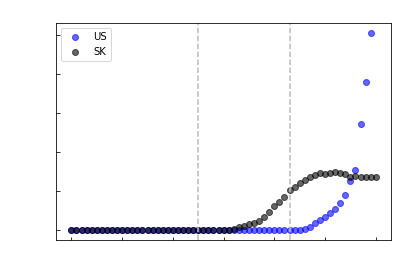

In [0]:
plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US and SK Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.axvline(x=25, color = "#BBBBBB", linestyle="dashed") # Put vertical lines at shift.
plt.axvline(x=43, color = "#BBBBBB", linestyle="dashed")
plt.scatter(i_US, X_US, alpha = 0.6, color = 'b', label="US")  # USA
# plt.scatter(i_SK, X_SK, alpha = 0.6, color = 'r')  # Adjusted SK (To have end cut off later to adjust to US shift, so end is flat from processing)
plt.scatter(i_SK, y_SK, alpha = 0.6, color = 'k', label="SK")  # Actual SK
plt.legend(loc="upper left")
plt.show()

In [0]:
# Shift by 20, gives us ~2 weeks of prediction.
shift =  18
X_US = X_US[shift:]
i_US = i_US[shift:] - shift

X_SK = X_SK[: len(X_US)]
i_SK = i_SK[: len(X_US)]

if len(X_SK) != len(X_US) or not np.array_equal(i_US, i_SK):
  print("Something has gone terribly wrong!")
else:
  print("SK and US data successfully aligned")

SK and US data successfully aligned


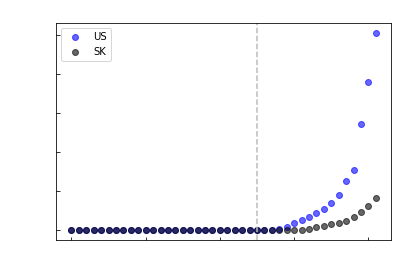

In [0]:
plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US and SK Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.axvline(x=25, color = "#BBBBBB", linestyle="dashed") # Put vertical lines at shift.
plt.scatter(i_US, X_US, alpha = 0.6, color='b', label="US")
plt.scatter(i_SK, X_SK, alpha = 0.6, color='k', label="SK")
plt.legend(loc="upper left")
plt.show()

In [0]:
# Match X to y before fitting
# print(X_SK.shape)
# print(X_US.shape)
# print(y_SK.shape)
shift = y_SK.shape[0] - X_SK.shape[0]
# print(shift)
start = X_SK.shape[0] - shift
# print(start)
end = X_SK.shape[0]

X_SK_chop = X_SK[:start]
X_US_chop = X_US[:start]
X_SK = X_SK[start:]
X_US = X_US[start:]
y_SK = y_SK[end:]

# print(X_SK.shape)
# print(X_US.shape)
# print(y_SK.shape)
# print(X_US.dtype)

# normalization
norm_X_SK = np.max(X_SK)
X_SK = X_SK / norm_X_SK

norm_X_US = np.max(X_US)
X_US = X_US / norm_X_US

norm_y_SK = np.max(y_SK)
y_SK = y_SK / norm_y_SK

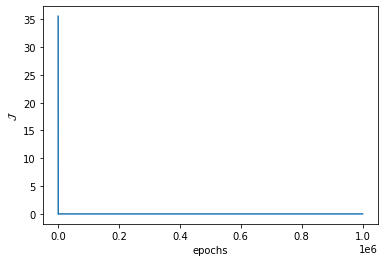

In [0]:
# The meat and the potatoes

architecture = [30, 30, 30]  # Number of neurons for each layer.
activations = [np.tanh]*len(architecture)  # Activation function for each layer.

# Note: Sometimes gives choppy/spikey results due to LOTS of local minima for J, may need to re-run if this happens
ann_reg = ANN(architecture, activations, 1)
ann_reg.fit(X_SK, y_SK, eta=1e-2, epochs=1e6, show_curve=True)
y_hat_SK = ann_reg.predict(X_SK)
y_hat_US = ann_reg.predict(X_US)

In [0]:
print(R2(y_SK, y_hat_SK))
print("R2: " + str(np.mean(R2(y_SK, y_hat_SK))))
# print("R2: " + str(np.corrcoef(y_SK, y_hat_SK)[0, 1]**2))

[[0.20631956]
 [0.0923972 ]
 [0.03657391]
 [0.04553199]
 [0.08002582]
 [0.14938506]
 [0.12555992]
 [0.02442083]
 [0.03225751]
 [0.0209153 ]
 [0.00648357]
 [0.00586648]
 [0.02045862]
 [0.01184663]
 [0.01180565]
 [0.00163402]
 [0.00516116]
 [0.00171989]
 [0.00213852]]
R2: 0.04634219194337141


In [0]:
# Turn back into real values and create full arrays.
X_SK = X_SK * norm_X_SK
X_US = X_US * norm_X_US
y_SK = y_SK * norm_y_SK

y_hat_SK = y_hat_SK * norm_y_SK
y_hat_US = y_hat_US * norm_X_US

y_SK_Original = np.concatenate((X_SK_chop, X_SK, y_SK))
y_SK_Pred = np.concatenate((X_SK_chop, X_SK, y_hat_SK))
y_US_Pred = np.concatenate((X_US_chop, X_US, y_hat_US))

ind = np.linspace(0, len(y_US_Pred), len(y_US_Pred))

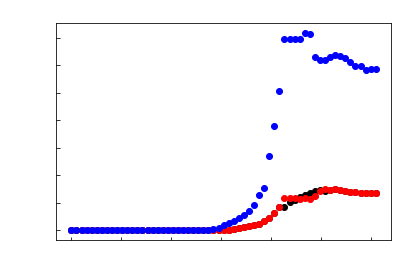

In [0]:
plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US and SK Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.scatter(ind, y_SK_Original, color='k')
plt.scatter(ind, y_SK_Pred, color='r')
plt.scatter(ind, y_US_Pred, color='b')
plt.show()

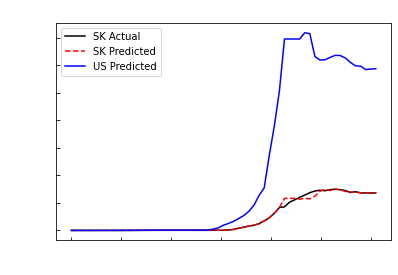

In [0]:
plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US and SK Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.plot(ind, y_SK_Original, color='k', label="SK Actual")
plt.plot(ind, y_SK_Pred, color='r', linestyle="dashed", label="SK Predicted")
plt.plot(ind, y_US_Pred, color='b', label="US Predicted")
plt.legend(loc="upper left")
plt.show()

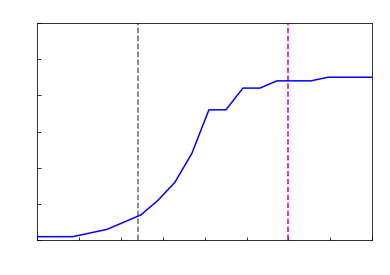

In [0]:
# DOW/Market Crash was on 2/27/20. We shifted USA by 18, so the start of the set/crash is now 20 instead of 38. 7-8 days before exponential growth,
# and 10 days after cases starting growing in the USA.

plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.ylim(0, 60)
plt.xlim(5, 25)
plt.axvline(x=11, color = "#696969", linestyle="dashed") # Put vertical lines at shift.
plt.axvline(x=20, color = "m", linestyle="dashed") # Put vertical lines at shift.
plt.plot(ind, y_US_Pred, color='b')
plt.show()

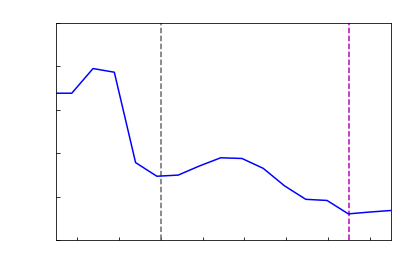

In [0]:
# Similarly for stabalization:

plt.figure()
plt.xlabel("Days", color='w')
plt.ylabel("Number of Active Cases", color='w')
plt.title("US Active Cases", color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.tick_params(direction="in")
plt.ylim(28000, 38000)
plt.xlim(45, 61)
plt.axvline(x=50, color = "#696969", linestyle="dashed") # Start Stab, 3/28/20
plt.axvline(x=59, color = "m", linestyle="dashed") # 9 Days after Stab, 4/6/20
plt.plot(ind, y_US_Pred, color='b')
plt.show()

In [0]:
print(y_US_Pred)

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.00000000e+00]
 [3.00000000e+00]
 [5.00000000e+00]
 [7.00000000e+00]
 [1.10000000e+01]
 [1.60000000e+01]
 [2.40000000e+01]
 [3.60000000e+01]
 [3.60000000e+01]
 [4.20000000e+01]
 [4.20000000e+01]
 [4.40000000e+01]
 [4.40000000e+01]
 [4.40000000e+01]
 [4.50000000e+01]
 [4.50000000e+01]
 [4.50000000e+01]
 [4.50000000e+01]
 [4.50000000e+01]
 [6.60000000e+01]
 [2.40000000e+02]
 [4.80000000e+02]
 [9.59000000e+02]
 [1.28100000e+03]
 [1.66300000e+03]
 [2.17400000e+03]
 [2.71700000e+03]
 [3.47800000e+03]
 [4.59400000e+03]
 [6.37200000e+03]
 [7.72500000e+03]
 [1.35790000e+04]
 [1.89860000e+04]
 [2.53190000e+04]
 [3.47641538e+04]
 [3.47641538e+04]
 [3.47641538e+04]
 [3.47641538e+04]
 [3.58991579e+04]
 [3.57299666e+04]
 [3.15733756e+04]
 [3.09463399e+04]
 [3.09979524e+04]
 [3.14177460e+04]
 [3.17947985e+04]
 [3.17632714e+04]
 [3.13089687e+04]
 [3.050496